Kinship matrix with singularities
============================================

In this notebook we use the kinsheep matrix from kinAB_FlintSYNrep2 that contains small singular values. We compare the performance of different numerical algorithms for solution of GBLUP problem.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.linalg
from scipy.sparse.linalg import cg, minres
import pandas as pd

from matplotlib import pylab
import seaborn as sbs
sbs.set_context("talk")

filename_data = "data/GenoFlintSYNrep2.csv"
filename_target = "data/PhenoFlintSYNrep2.csv"
filename_kin = "data/kinAB_FlintSYNrep2.csv"
lambda_ = 1e-3

data_df = pd.DataFrame.from_csv(filename_data)
data = data_df.as_matrix()
X = data

kin_df = pd.DataFrame.from_csv(filename_kin)
kin_data = kin_df.as_matrix()
K = kin_data 

targets_df = pd.DataFrame.from_csv(filename_target)
targets = targets_df.as_matrix()
y = targets[:,2]

## Solution of Kernel Equations

We start by computing the left-handside matrix $A = \K + \lambda *I$ and solve the system of equations
$$ A x = \y.$$

In [2]:
A = K + lambda_ * np.eye(K.shape[0])

### Using CG

In [12]:
%timeit -n 10 -r 3 res_cg = cg(A, y, tol=1e-12)
res_cg = cg(A, y, tol=1e-12)

10 loops, best of 3: 17.8 ms per loop


### Using MINRES

In [13]:
# solve system using minres
%timeit -n 10 -r 5 res_minres = minres(A, y, tol=1e-12)
res_minres = minres(A, y, tol=1e-12)

10 loops, best of 5: 25.4 ms per loop


### Using Cholesky factorization of $A$

Since this solution method consists for two steps: Cholesky factorization of $A$ and backsubsitution, we measure this steps indivudally.

**Cholesky factorization:**

In [19]:
# perform Cholesky factorization
%timeit -n 10 -r 5 sp.linalg.cho_factor(A)
L, is_lower = sp.linalg.cho_factor(A)

10 loops, best of 5: 1.68 ms per loop


**Backsubstitution:**

In [20]:
# perform Cholesky backsubstitution
%timeit -n 10 -r 5 sp.linalg.cho_solve((L, is_lower), y)
x_cholesky = sp.linalg.cho_solve((L, is_lower), y)

10 loops, best of 5: 354 µs per loop


### Using Eigenvalue decomposition of $A$

Again, the solution method consists for two steps: eigenvalue decomposition of $A$ and backsubsitution.

**Eigenvalue decomposition:**

In [7]:
# eigenvalue decomposition of the matrix K
%timeit -n 10 -r 5 W,VR = sp.linalg.eig(A)
W,VR = sp.linalg.eig(A)

10 loops, best of 5: 92.6 ms per loop


**Backsubsitution:** (we program it explicitly since there is no buit-in method)

In [8]:
# eigenvalues backsubstitution
%timeit -n 10 -r 5  VR.dot(VR.T.dot(y)*(1./W.real))
x_ev = VR.dot(VR.T.dot(y)*(1./W.real))

10 loops, best of 5: 84.5 µs per loop


# Timing Results Summary

I summarize the measurements in the table below. The measurements may vary from one run of the notebook to another hence they not necessarily coincide with currently presented time measurements above.

| Method               |  Decompositon | Solution  | Total         |
|----------------------|---------------|-----------|---------------|
| CG                   |               | 17.8 ms   | 17.8 ms    |
| MINRES               |               | 25.4 ms   | 25.4 ms   |
| Eigenval. decom. $A$ |     92.6 ms   |0.0845 ms | 92.6845 ms |
| Cholesky             |  1.68 ms      | 0.354 ms  | **ca 2 ms** |



# Verification

We plot the computed values of $\lambda$ against each other  to verify that they all lie on the same lines.m

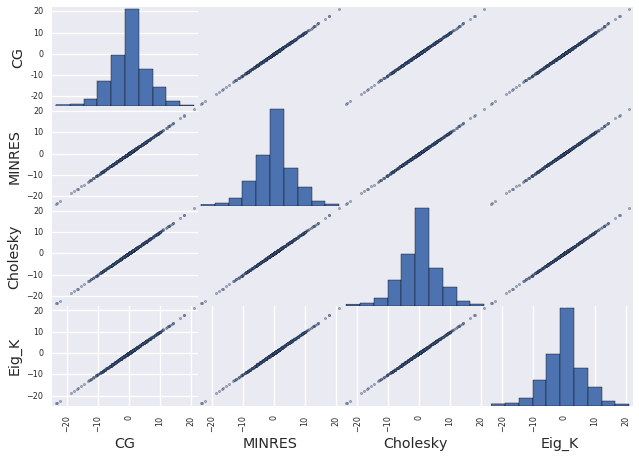

In [9]:
import pandas as pd

alphas = pd.DataFrame(np.vstack([res_cg[0], res_minres[0], x_cholesky, x_ev]).T, 
                           columns=['CG', 'MINRES', 'Cholesky', 'Eig_K'])

plot = pd.scatter_matrix(alphas)

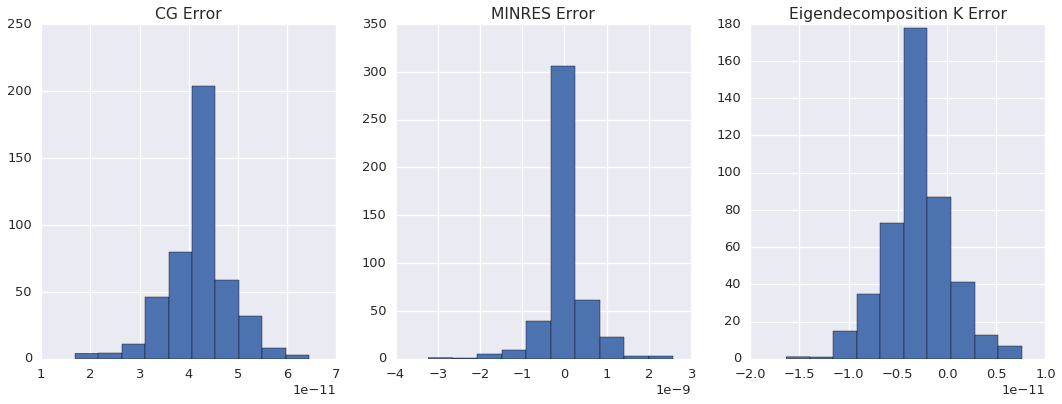

In [14]:
alphas = pd.DataFrame(np.vstack([res_cg[0], res_minres[0], x_cholesky, x_ev]).T, 
                           columns=['CG', 'MINRES', 'Cholesky', 'Eig_K'])

pylab.figure(figsize=(18,6))
pylab.subplot(1,3,1)
pylab.hist(alphas.Cholesky-alphas.CG)
pylab.title("CG Error")
pylab.subplot(1,3,2)
pylab.hist(alphas.Cholesky-alphas.MINRES)
pylab.title("MINRES Error")
pylab.subplot(1,3,3)
pylab.hist(alphas.Cholesky-alphas.Eig_K)
pylab.title("Eigendecomposition K Error")


## Numerics of Eigenvalues and Singular Values



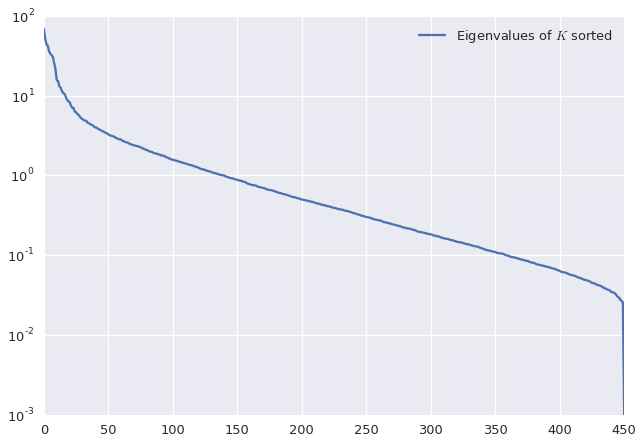

In [11]:

pylab.plot(sorted(W.real, reverse=True), '-', label=r"Eigenvalues of $K$")

pylab.yscale("log")

pylab.legend(loc='best')